In [75]:
# Importing libraries

import operator
from typing_extensions import TypedDict
from typing import List, Annotated, Union
from IPython.display import display, Image

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.documents import Document
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode

from utils.logger import logger
from src.checkpoints.retrieval_grading import grade_retrieval
from src.checkpoints.routering import get_routing_decision
from src.embedding.vector_store import VectorStore
from src.embedding.embedding_models import EmbeddingModels

/Users/drakezhou/Development-Projects/LangchainRag_Ollama/venv/langchain_ollama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [97]:
class GraphState(TypedDict): 
    """
    Graph state is a dictinary that contains information we want to propagte to, and modify in, each graph node
    """
    # User input
    question: str  # User question
    conversation: List[Union[HumanMessage, AIMessage, SystemMessage]]

    # Models
    llm_model: str = "llama3.2" # Name of the LLM model
    embedding_model: str = "BAAI/bge-m3"  # Name of the embedding model

    # LLM generated variables
    intention: str  # Intention of the user
    retrieved_documents: List[Document]
    filtered_documents: List[Document]
    generated_answers: str

    # Parameters
    number_of_answers: int # Number of answers to generated
    loop_step: Annotated[int, operator.add]
    max_retries: int = 3  # Maximum number of retries for the LLM
    generation: str # LLM generation answer
    
class ReasonedDocument:
    
    document: Document
    relevance_score: float
    reasoning: str
    
    def __init__(self, document, relevance_score, reasoning):
        self.document = document
        self.relevance_score = relevance_score
        self.reasoning = reasoning
        
    def __str__(self):
        return f"Document: {self.document}\nRelevance Score: {self.relevance_score}\nReasoning: {self.reasoning}\n"

In [163]:
from src.answer_generation import generate_answer


# @tool(response_format="content_and_artifact")
def graph_intention_detection(graph_state: GraphState) -> GraphState:
    """
    Graph intention detection is a function that takes in a graph state and returns a graph state
    """
    intention = get_routing_decision(
        messages=[HumanMessage(content=graph_state['question'])],
        model="llama3.2",
    )

    logger.info(f"Detected user intention: {intention['knowledge_base']}")

    return {
        'intention': intention['knowledge_base']
    }
    
# @tool(response_format="content_and_artifact")
def graph_retrieve_documents(graph_state: GraphState) -> GraphState:
    """
    Retrieve documents is a function that takes in a graph state and returns a graph state
    """
    if graph_state['intention'] == 'research':
        vectorstore_path = './data/vector_database/research_kb'
    else:
        vectorstore_path = './data/vector_database/peer_kb'
        
    embedding_model = EmbeddingModels().get_bge_embedding('BAAI/bge-m3')    
    
    chroma_vectorstore = VectorStore().get_chroma_vectorstore(
        vectorstore_path=vectorstore_path,
        embedding=embedding_model
    )

    documents = VectorStore().retrieve_docs(
        query=graph_state['question'],
        vectorstore=chroma_vectorstore,
        k=5
    )

    return {
        'retrieved_documents': documents
    }

# Router user intention to the correct graph node
def graph_router_user_intention(graph_state: GraphState) -> GraphState:
    """
    Graph router user intention is a function that takes in a graph state and returns a graph state
    """
    
    # TODO: Set vectorstore path based on user intention
    # TODO: Set prompt template based on user intention
    
    if graph_state['intention'] == 'research':
        return "RESEARCH"
    else:
        return "PEER_SUPPORT"

# Grade relevant documents.     
def graph_retrieval_grading(graph_state: GraphState) -> GraphState:
    """
    Graph retrieval grading is a function that takes in a graph state and returns a graph state
    """
    graded_documents = grade_retrieval(
        question=graph_state['question'],
        retrieved_docs=graph_state['retrieved_documents'],
        model="llama3.2",
    )
    
    # Filter out documents with relevance_score lower than 0.5 and re-rank relevant documents based on relevance_score descending
    
    filtered_docs = []
    
    for doc, grade in zip(graph_state['retrieved_documents'], graded_documents):
        if grade["relevance_score"] >= 0.5:
            reasoned_doc = ReasonedDocument(
                document=doc,
                relevance_score=grade["relevance_score"],
                reasoning=grade["reasoning"]
            )
            filtered_docs.append(reasoned_doc)
    
    
    # Re-rank the filtered documents based on relevance_score in descending order
    filtered_docs.sort(key=lambda x: x.relevance_score, reverse=True)
        
    return {
        'filtered_documents': filtered_docs
    }
    

def graph_router_retry_similarity_search(graph_state: GraphState) -> GraphState:
    """
    Graph router retry similarity search is a function that takes in a graph state and returns a graph state
    """
    filtered_documents = graph_state['filtered_documents']
    
    if len(filtered_documents) < 0:
        return "RETRY_SIMILARITY_SEARCH"
    else:
        return "PROCEED"
    
def graph_generate_answer(graph_state: GraphState) -> GraphState:
    """
    Graph generate answer is a function that takes in a graph state and returns a graph state
    """
    logger.info(f"Generating answer with model: {graph_state['llm_model']} / marco-o1")
    
    context = [doc.document for doc in graph_state['filtered_documents']]
    
    res = generate_answer(
        question=graph_state['question'],
        context_chunks=context,
        model="llama3.2",
        temperature=0.5
    )
    
    print(res)
    
    return {
        'generated_answers': res
    }
    

In [164]:
workflow = StateGraph(GraphState)

# Nodes in workflow
workflow.add_node("INTENTION_DETECTION", graph_intention_detection)
workflow.add_node(graph_retrieve_documents)
workflow.add_node(graph_retrieval_grading)
# workflow.add_node(graph_router_retry_similarity_search)
workflow.add_node(graph_generate_answer)

# Sequencely defined workflow edges
workflow.set_entry_point("INTENTION_DETECTION")
workflow.add_conditional_edges(
    "INTENTION_DETECTION",
    graph_router_user_intention,
    {
        "RESEARCH": "graph_retrieve_documents",
        "PEER_SUPPORT": "graph_retrieve_documents"
    }
)
workflow.add_edge("graph_retrieve_documents", "graph_retrieval_grading")
# workflow.add_edge("graph_retrieval_grading", END)
workflow.add_conditional_edges("graph_retrieval_grading", graph_router_retry_similarity_search, {
    "PROCEED": "graph_generate_answer",
    "RETRY_SIMILARITY_SEARCH": "graph_retrieve_documents"
})
workflow.add_edge("graph_generate_answer", END)

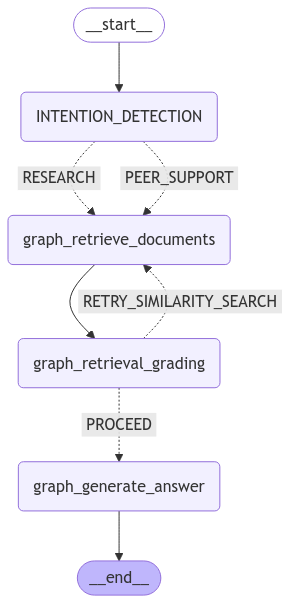

In [165]:
graph_compiled = workflow.compile()
display(Image(graph_compiled.get_graph().draw_mermaid_png()))

In [166]:
inputs = {
    'question': 'how to take care of Alzheimer\'s disease? parents.',
    'conversation': [],
    'llm_model': 'llama3.2',
    'embedding_model': 'BAAI/bge-m3',
}

for step in graph_compiled.stream(input=inputs, stream_mode="values"):
    print(step)
    print("\n")

{'question': "how to take care of Alzheimer's disease? parents.", 'conversation': [], 'llm_model': 'llama3.2', 'embedding_model': 'BAAI/bge-m3', 'loop_step': 0}


2025-01-15 @ 03:26:57 | INFO     | src.checkpoints.routering:get_routing_decision:48 - Processing question: how to take care of Alzheimer's disease? parents.
2025-01-15 @ 03:26:58 | INFO     | src.checkpoints.routering:get_routing_decision:64 - Routing decision: {'knowledge_base': 'peer_support'}
2025-01-15 @ 03:26:58 | INFO     | __main__:graph_intention_detection:14 - Detected user intention: peer_support
{'question': "how to take care of Alzheimer's disease? parents.", 'conversation': [], 'llm_model': 'llama3.2', 'embedding_model': 'BAAI/bge-m3', 'intention': 'peer_support', 'loop_step': 0}


2025-01-15 @ 03:26:58 | INFO     | src.embedding.embedding_models:get_bge_embedding:28 - Using device: mps
2025-01-15 @ 03:26:58 | INFO     | src.embedding.embedding_models:get_bge_embedding:29 - Loading BGE embedding model: BAAI/bge-